# Encoding Time Series Data as Image Fields #

Time Series Imaging is a way to create images from univariate or multivariate (using stacking) time series data and allows us to leverage the sophisticated AI technologies and pretrained models developed for Image Classification. Put simply, it allows machines to “visually recognize” labelled time series data, and to do so with relatively few training examples. 

Aretas platform has 4 image field generators for time series sensor data.

1. Gramian Angular Summation Field (GASF)
2. Gramian Angular Difference Field (GADF)
3. PASF (Angular Summation Field (Aretas algorithm))
4. PADF (Angular Difference Field (Aretas algorithm))

In addition, the time series data fed into the image field generators can be 
1. Outlier filtered
2. Interpolated / decimated (feature preserving decimation)
3. Moving averaged

An example of the Aretas image field encoders (with a sparse sine sample input):

<img src="./notebook-images/sine-sample.png">

### Sample Image Field Outputs (from sine input) ###

| GASF | GADF | PASF | PADF |
| --- | --- | --- | --- |
| 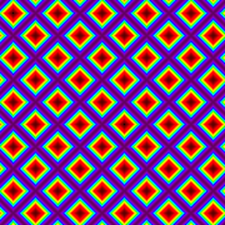|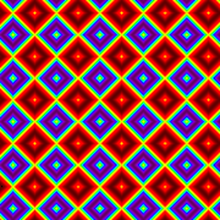|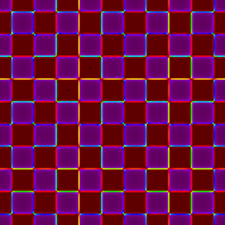|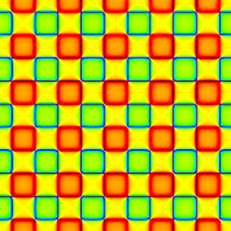

In the Aretas platform API, Image Fields can be scaled, interpolated, rotated and stacked in different orientations. Images can be palettized with several different palettes. 

Multiple sensors and analytes can be combined. Training data sets can be produced from platform labeled data. 

### Example tVOC sensor being exposed to different VOCs: ###

<img src="./notebook-images/tvoc-different-events-example.jpg">

### Palettized image examples (several other palettes available) ###

Thermal palette (stacked analytes temp, relative humidity, CO2 and VOC):
<img src="./notebook-images/stacked-analyte-thermal-palette.png">

Visual Spectrum palette (stacked analytes):
<img src="./notebook-images/stacked-analyte-vision-palette.png">



## Synthetic Data Example ##

The Aretas platform has several sensor data generators for generating sample events, ambient data and function representations for simulations over "real time" (for internal testing of alerting algorithms, anomaly detection and AI training and testing). Synthetic event testing provides simplified proof for the methodology. 

### Ambient Data ###
For this experiment, ambient CO2 data is synthesized over a 60 minute perioud with 400 ppm ambient baseline and +/- 20ppm of gaussian noise (randomized). 
<img src="./notebook-images/sample-ambient-CO2.png" width="500">

### Synthetic Events ###
Synthetic events are generated (similar to classified events in the platform) where a small amount of ambient data precedes a rise to 1000 ppm of CO2, which then rises to 1500 ppm, then a decline back to ambient. The ambient data contains +/-20ppm of noise and the 1000ppm and 1500ppm events contain +/-200ppm of noise
<img src="./notebook-images/sample-event-1-CO2.png" width="400">
<img src="./notebook-images/sample-event-2-CO2.png" width="400">

### Experiment ###
We will use transfer learning to fine tune a pretrained network (resnet) on 50 randomized samples of ambient data as Image Fields and 50 randomized samples of event data as Image Fields and demonstrate the classification accuracy using Gramian Image and Aretas Image Fields. We will withhold 20% of the training data for validation. 

In [1]:
from fastai.vision.all import *

In [2]:
image_data_path = Path("test-batches/gaf-batch-normalized-gasf")

In [3]:
image_data_path.ls()

(#3) [Path('test-batches/gaf-batch-normalized-gasf/0'),Path('test-batches/gaf-batch-normalized-gasf/1'),Path('test-batches/gaf-batch-normalized-gasf/models')]

In [4]:
files = get_image_files(image_data_path)

In [5]:
len(files)

100

In [6]:
files[0]

Path('test-batches/gaf-batch-normalized-gasf/0/GAF-simulated-data-sample-1666762882394.png')

In [7]:
files[0].parts[3]

'GAF-simulated-data-sample-1666762882394.png'

We provide a label function for the labeled training data from the file folder (0 = ambient and 1 = event)

In [8]:
def label_func(f):
    label = f.parts[2]
    return label


In [9]:
dls = ImageDataLoaders.from_path_func(image_data_path, files, label_func, valid_pct=0.2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


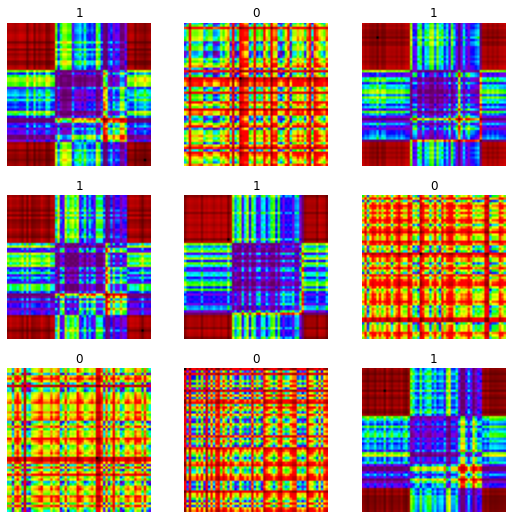

In [10]:
dls.show_batch()

C:\Users\willow\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\willow\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0006918309954926372)

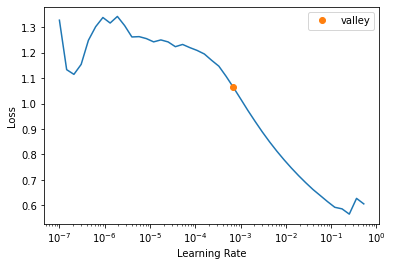

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.lr_find(num_it=50)

In [12]:
lr = 10e-3
learn.fine_tune(10, lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.071595,1.432299,0.450000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,0.974653,1.162204,0.450000,00:00
1,0.573292,0.677979,0.250000,00:00
2,0.397015,0.063795,0.000000,00:00
3,0.296061,0.005213,0.000000,00:00
4,0.235439,0.000278,0.000000,00:00
5,0.194232,0.000030,0.000000,00:00
6,0.164820,0.000011,0.000000,00:00
7,0.142749,0.000009,0.000000,00:00
8,0.125587,0.000008,0.000000,00:00
9,0.111876,0.000007,0.000000,00:00


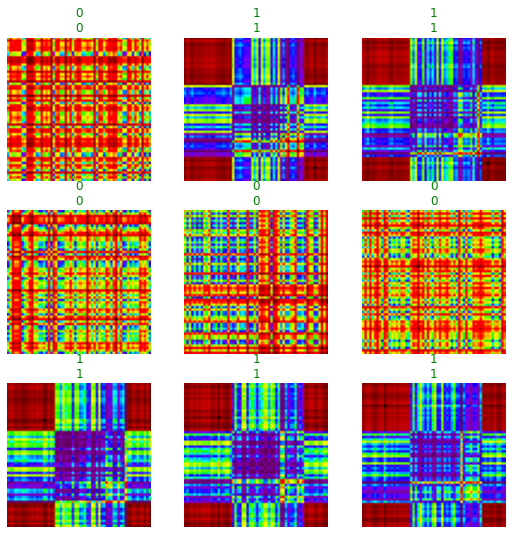

In [13]:
learn.show_results()

In [14]:
interp = Interpretation.from_learner(learn)

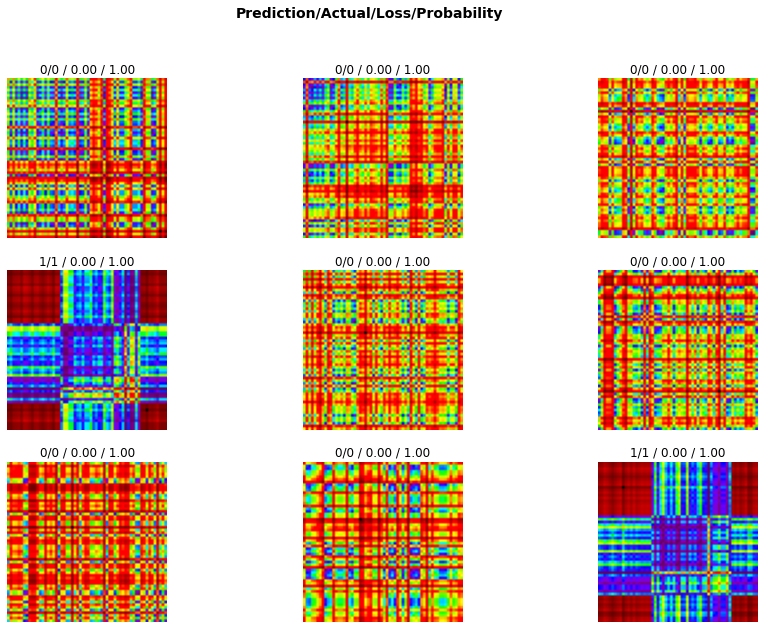

In [15]:
interp.plot_top_losses(9, figsize=(15,10))

In this example, we use one of the Aretas Image Field functions (rather than Gramian Image Fields)

In [16]:
image_data_path = Path("test-batches/gaf-batch-normalized-padf")
files = get_image_files(image_data_path)
dls = ImageDataLoaders.from_path_func(image_data_path, files, label_func, valid_pct=0.2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


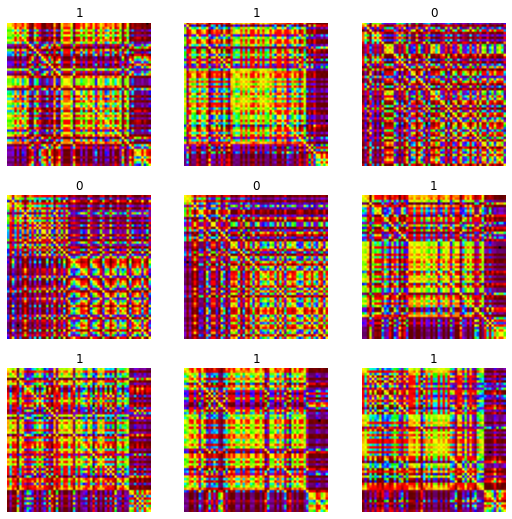

In [17]:
dls.show_batch()

SuggestedLRs(valley=0.0020892962347716093)

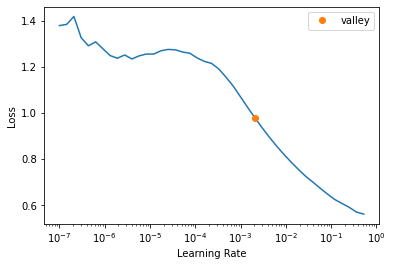

In [18]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.lr_find(num_it=50)

In [19]:
lr = 8e-3
learn.fine_tune(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.214171,1.576356,0.600000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,1.004134,1.617936,0.600000,00:00
1,0.625427,1.454780,0.600000,00:00
2,0.438751,0.786265,0.700000,00:00
3,0.327083,0.417252,0.750000,00:00
4,0.261500,0.254301,0.850000,00:00
5,0.216045,0.161606,0.900000,00:00
6,0.183552,0.129034,0.950000,00:00
7,0.159177,0.073315,0.950000,00:00
8,0.140225,0.055704,0.950000,00:00
9,0.124917,0.036761,1.000000,00:00


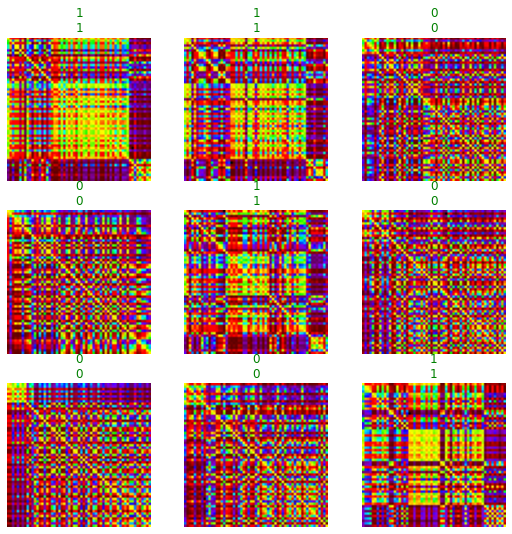

In [20]:
learn.show_results()

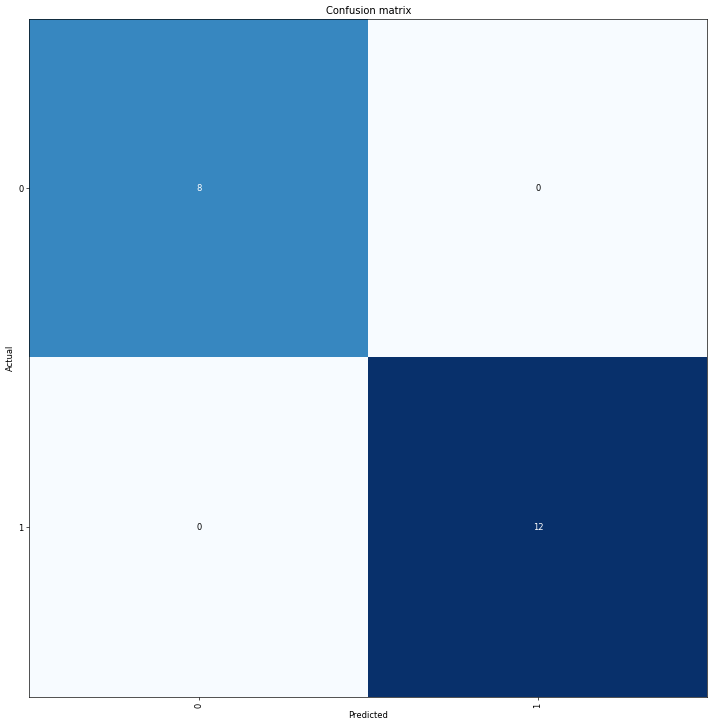

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)